In [1]:
from tvb.simulator.lab import *
import numpy as np
from tvb.simulator.backend.dopa_backend import DOPABackend
from tvb.simulator.backend.izimf_backend import IZIMFBackend
from tvb.simulator.backend.nb_mpr import NbMPRBackend
import matplotlib.pyplot as plt

/home/danie/tvb/tvb-root/tvb_library/tvb/datatypes/surfaces.py:60: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


In [2]:
# load connectivities
conn_dopamine=np.load("conn_dopamine.npy")
#conn_dopamine=np.zeros((88,88)).astype('float64')
conn_excitator=np.load("conn_excitator.npy")
conn_inhibitor=np.load("conn_inhibitor.npy")
#conn_inhibitor=np.zeros((88,88)).astype('float64')

# configure connectivy for TVB
conn = connectivity.Connectivity()
conn.region_labels = np.array(["L.BSTS", "L.CACG", "L.CMFG", "L.CU", "L.EC", "L.FG", "L.IPG", "L.ITG", "L.ICG","L.LOG", "L.LOFG", "L.LG", "L.MOFG", "L.MTG", "L.PHIG", "L.PaCG", "L.POP", "L.POR","L.PTR", "L.PCAL", "L.PoCG", "L.PCG", "L.PrCG", "L.PCU", "L.RACG", "L.RMFG", "L.SFG",
    "L.SPG", "L.STG", "L.SMG", "L.FP", "L.TP", "L.TTG", "L.IN", "L.CER", "L.TH", "L.CA","L.PU", "L.HI", "L.AC", "lh-GPe", "lh-GPi", "lh-STN", "rh-GPe","rh-GPi", "rh-STN", "R.TH", "R.CA", "R.PU", "R.HI",  "R.AC", "R.BSTS",
    "R.CACG", "R.CMFG", "R.CU", "R.EC", "R.FG", "R.IPG", "R.ITG", "R.ICG", "R.LOG","R.LOFG", "R.LG", "R.MOFG", "R.MTG", "R.PHIG", "R.PaCG", "R.POP", "R.POR", "R.PTR","R.PCAL", "R.PoCG", "R.PCG", "R.PrCG", "R.PCU", "R.RACG", "R.RMFG", "R.SFG", "R.SPG",
    "R.STG", "R.SMG", "R.FP", "R.TP", "R.TTG", "R.IN", "R.CER","SubstantiaNigraLH","SubstantiaNigraRH"])
conn.centres = np.zeros((3,88)) # just some trick to create the object in TVB
conn.weights = conn_excitator # inhibitory and dopamine connectivity has to be introduced later (multiple connectivites not implemented in TVB)
conn.tract_lengths = (conn_excitator*.0+100).astype('i') # another trick, we won't be using delays
conn.configure()

# Dopamine model

\begin{align}
\begin{split}
& \frac{dr}{dt} = 2arV + br - (A_{Dp}[D_p]+B_{Dp})g_aS_ar - g_gS_gr + \frac{a\Delta}{\pi} \\
& \frac{dV}{dt} =  aV^2 + bV + c + \eta - \frac{\pi^2  r^2}{a} +(A_{Dp}[D_p]+B_{Dp}) g_aS_a(E_a-V) +g_gS_g(E_g-V)  - u + I_{ext} \\
& \frac{du}{dt} = \alpha(\beta V - u) + u_dr \\
& \frac{dS_g}{dt} = \frac{-S_g}{\tau_{S_g}} + S_{jg}c_{inh} \\ 
& \frac{d[D_p]}{dt} = k c_{dopa}-\frac{V_{max}[D_p]}{(K_m+[D_p])} \\
& \end{split}
\end{align}

Now we have more equations than the Montbrio model. Though not so different because they are constructed from similar single neuron model. We find additional synaptic terms in r and v that are linked to specific connectivity links in the network. Cortical projections are considered excitatory and are the ones we used in the example of Montbrio. Let's lookt at the connectivities :

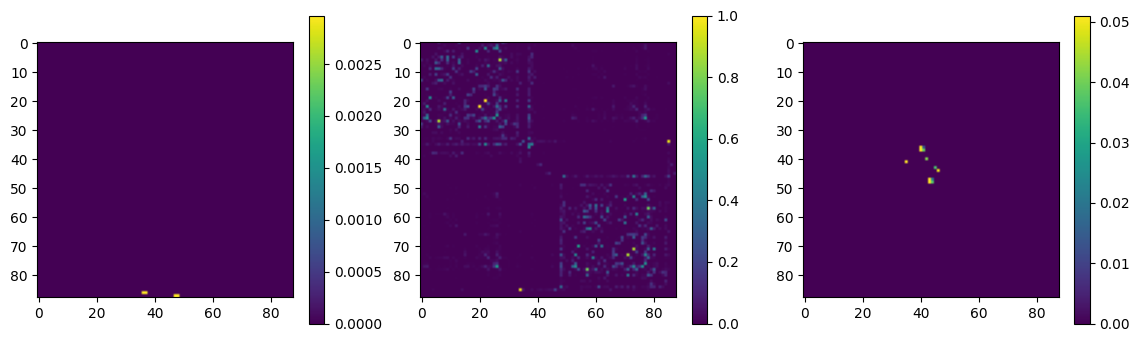

In [3]:
fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(14,5))
im = ax.imshow(conn_dopamine, vmax=conn_dopamine.max()/10)
plt.colorbar(im, shrink=.8, ax=ax)
im2 = ax2.imshow(conn_excitator)
plt.colorbar(im2, shrink=.8, ax=ax2)
im3 = ax3.imshow(conn_inhibitor, vmax=conn_inhibitor.max()/10)
plt.colorbar(im3, shrink=.8, ax=ax3)
plt.show()

The middle one is the one we know. \
The left one are the dopamine connections from the substatia nigra to...?\
The right one are inhibitory connections from ... to ? \
You can look for the answer.

# Let's run a simuation with some starting parameters :

In [4]:

# Now we have 3 coupling factors :
g_dopa, g_excit, g_inhib = np.array([9e-1]), 7e-2, np.array([1.7e-2])

nsigma = 0.03
n_nodes = 88
r0, V0, u0, sa0, sg0, Dp0 = 0.2, -70.0, 0.0, 0.0, 0.0, 0.05
init_cond = np.array([r0, V0, u0, sa0, sg0, Dp0])
initial_cond = np.repeat(init_cond, n_nodes).reshape((1, 6, 88, 1))
r0s = np.random.uniform(high=1., low=0., size=(1, 1, 88, 1))
v0s = np.random.uniform(high=-50., low=-100., size=(1, 1, 88, 1))
initial_cond[:,:1,:,:] = r0s
initial_cond[:,1:2,:,:] = v0s

In [5]:
izm = models.IziMF()

In [6]:
sim = simulator.Simulator(
    model=izm,
    connectivity=conn,
    coupling=coupling.Linear(
        a=np.array([g_excit])
    ),
    conduction_speed=1.,
            integrator=integrators.HeunStochastic(
            dt=0.01,
            noise=noise.Additive(
                nsig=np.array(
                    [nsigma,nsigma*10,nsigma/5,nsigma/10,nsigma/10,nsigma/10]
                ), 
                noise_seed=42)
        ),
    monitors=[monitors.Raw()],
    initial_conditions=initial_cond
).configure()

In [7]:
dopa_backed = DOPABackend()
izimf_backed = IZIMFBackend()

In [9]:
(t, tavg), c = izimf_backed.run_sim(sim, conn_inhibitor, conn_dopamine, g_inhib, g_dopa, simulation_length=10000)


In [10]:
tavg[0].shape
arr = np.array(tavg)

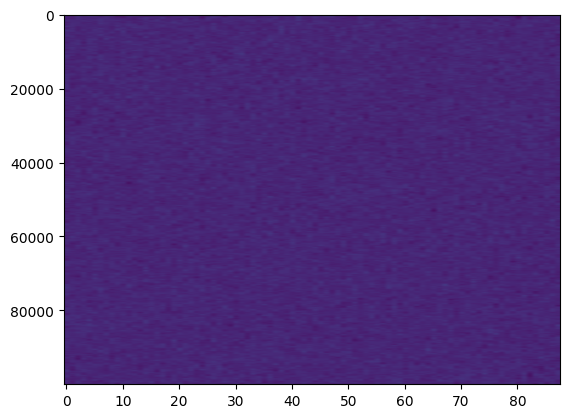

In [11]:
plt.imshow(arr[:,0,:], aspect='auto', vmax=2)

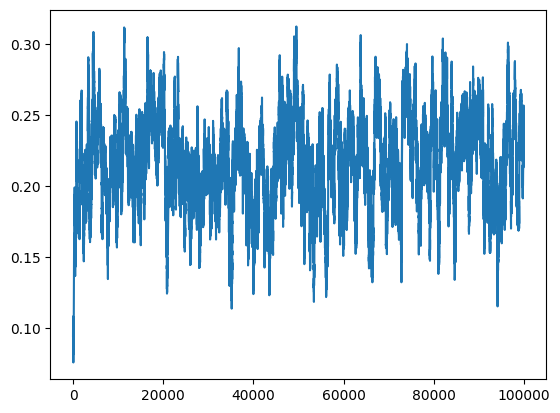

In [12]:
plt.plot(arr[:,0,0])

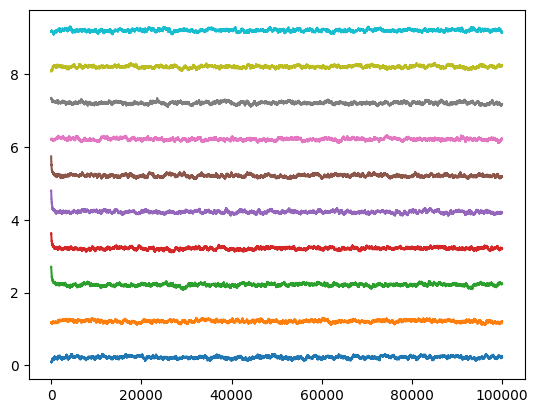

In [13]:
plt.plot(np.arange(10) + arr[:,0,:10])
plt.show()

In [ ]:
del sim

In [ ]:
g_dopa, g_excit, g_inhib = np.array([1.4e-1]), 7e-2, np.array([1.7e-2])
sim = simulator.Simulator(
    model=mdl,
    connectivity=conn,
    coupling=coupling.Linear(
        a=np.array([g_excit])
    ),
    conduction_speed=1.,
            integrator=integrators.HeunStochastic(
            dt=0.01,
            noise=noise.Additive(
                nsig=np.array(
                    [nsigma,nsigma*10,nsigma/10,nsigma/10, nsigma/10,nsigma/10]
                ), 
                noise_seed=42)
        ),
    monitors=[monitors.Raw()],
    initial_conditions=initial_cond
).configure()


In [ ]:
(t, tavg), = dopa_backed.run_sim(sim, conn_inhibitor, conn_dopamine, g_inhib, g_dopa, simulation_length=10000)

In [ ]:
plt.plot(np.arange(10) + tavg[:,0,:10])
plt.show()